Loaded 17379 rows, 43 features from bike_binarized.csv
null
Finding Optimal Objective...
treefarms reported successful execution
training completed. Number of trees in the Rashomon set: 149
{
  "false": {
    "complexity": 0.009999999776482582,
    "loss": 0.025145290419459343,
    "name": "label",
    "prediction": 0
  },
  "feature": 13,
  "model_objective": 0.20186200737953186,
  "name": "hr <= 21.5",
  "reference": 1,
  "relation": "==",
  "true": {
    "false": {
      "false": {
        "complexity": 0.009999999776482582,
        "loss": 0.09137465059757233,
        "name": "label",
        "prediction": 1
      },
      "feature": 21,
      "name": "temp <= 0.3100000023841858",
      "reference": 1,
      "relation": "==",
      "true": {
        "complexity": 0.009999999776482582,
        "loss": 0.036998677998781204,
        "name": "label",
        "prediction": 0
      },
      "type": "integral"
    },
    "feature": 7,
    "name": "hr <= 6.5",
    "reference": 1,
    "rela

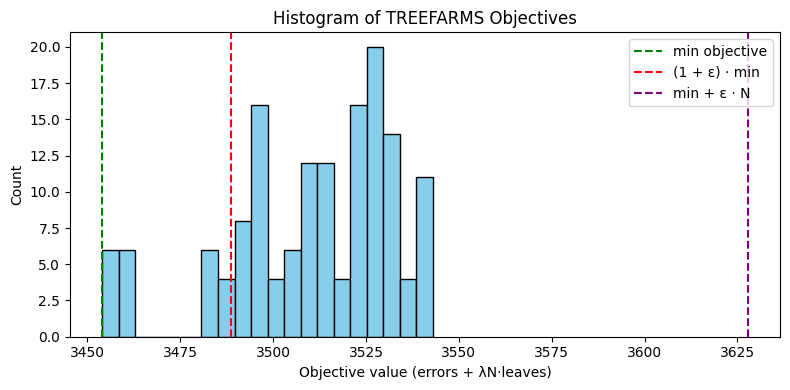

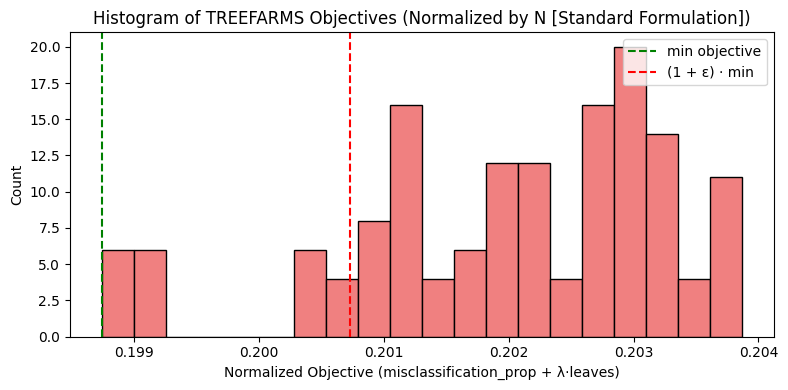


=== RESULT ===
algo               : TREEFARMS
data               : bike_binarized.csv
reg (lambda)       : 0.01
depth              : 4
rashomon_mult      : 0.01
time_sec           : 513.3780
peak_rss_mb        : 100012.5
num_trees          : 149


In [12]:
#!/usr/bin/env python3
import argparse, time, math, json
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

from memory_profiler import memory_usage

from resplit import RESPLIT
from licketyresplit import LicketyRESPLIT
from treefarms import TREEFARMS
from gosdt import GOSDTClassifier



## TreeFARMS Attempts
def structurally_equal(a, b):
    if type(a) != type(b):
        return False
    if hasattr(a, "prediction") and hasattr(b, "prediction"):
        return a.prediction == b.prediction
    if hasattr(a, "feature") and hasattr(b, "feature"):
        return (a.feature == b.feature and
                structurally_equal(a.left_child, b.left_child) and
                structurally_equal(a.right_child, b.right_child))
    return False

def tree_structure_signature(tree):  # hashable nested tuples
    if hasattr(tree, "prediction"):
        return ('leaf', int(tree.prediction))
    if hasattr(tree, "feature"):
        return ('node',
                int(tree.feature),
                tree_structure_signature(tree.left_child),
                tree_structure_signature(tree.right_child))
    raise ValueError(f"Unknown tree type: {type(tree)}")

def _collect_trees_from_treefarms(model, max_try=100000):
    trees, i = [], 0
    while i < max_try:
        try:
            t = model[i]
        except Exception:
            break
        trees.append(t)
        i += 1
   
    return trees

def _tree_errors(tree, X, y):
    N = len(y)
    if hasattr(tree, "score"):
        acc = float(tree.score(X, y))
        return int(round((1.0 - acc) * N)), acc
    raise RuntimeError("Tree does not expose .score(X,y)")

def _num_leaves(tree):
    if hasattr(tree, "leaves"):
        return int(getattr(tree, "leaves")())
    raise RuntimeError("Tree does not expose leaves()/num_leaves().")

def summarize_treefarms_objectives(model, X, y, reg, epsilon=0.01):
    trees = _collect_trees_from_treefarms(model)
    if not trees:
        raise RuntimeError("No trees retrieved from TREEFARMS (indexing/iter failed).")

    N = len(y)
    lamN = int(round(float(reg) * N))

    objs, err_list, leaf_list, acc_list = [], [], [], []
    for i, t in enumerate(trees):
        errs, acc = _tree_errors(t, X, y)
        leaves = _num_leaves(t)
        obj = errs + lamN * leaves
        objs.append(obj)
        err_list.append(errs)
        leaf_list.append(leaves)
        acc_list.append(acc)

    objs = np.asarray(objs, dtype=float)
    min_obj = float(np.min(objs))
    max_obj = float(np.max(objs))
    add_gap = max_obj - min_obj
    multiplicative_range = max_obj / min_obj # = 1 + x
    x = multiplicative_range - 1.0 # solve min*(1+x)=max

    cutoff = (1.0 + float(epsilon)) * min_obj
    passing_idx = [i for i, v in enumerate(objs) if v <= cutoff]

    print("\n[TREEFARMS Objective Summary]")
    print(f"trees: {len(trees)} | N: {N} | reg: {reg} | lamN: {lamN}")
    print(f"min_objective: {int(min_obj)}  |  max_objective: {int(max_obj)}")
    print(f"additive_gap (max - min): {int(add_gap)}")
    print(f"multiplicative_range = max/min = {multiplicative_range:.6f}  (x such that min*(1+x)=max is x = {x:.6f})")
    print(f"epsilon: {epsilon} | cutoff = min*(1+epsilon) = {cutoff:.6f}")
    print(f"trees within cutoff: {len(passing_idx)}  |  indices: {passing_idx}")

    plt.figure(figsize=(8, 4))
    plt.hist(objs, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(min_obj, color='green', linestyle='--', label='min objective')
    plt.axvline(cutoff, color='red', linestyle='--', label='(1 + ε) · min')
    plt.axvline(min_obj + epsilon * N, color='purple', linestyle='--', label='min + ε · N')

    plt.title("Histogram of TREEFARMS Objectives")
    plt.xlabel("Objective value (errors + λN·leaves)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    objs_normalized = [obj / N for obj in objs]
    min_obj_norm = min_obj / N
    cutoff_norm = cutoff / N

    plt.figure(figsize=(8, 4))
    plt.hist(objs_normalized, bins=20, color='lightcoral', edgecolor='black')
    plt.axvline(min_obj_norm, color='green', linestyle='--', label='min objective')
    plt.axvline(cutoff_norm, color='red', linestyle='--', label='(1 + ε) · min')

    plt.title("Histogram of TREEFARMS Objectives (Normalized by N [Standard Formulation])")
    plt.xlabel("Normalized Objective (misclassification_prop + λ·leaves)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "num_trees": len(trees),
        "lamN": lamN,
        "min_objective": min_obj,
        "max_objective": max_obj,
        "additive_gap": add_gap,
        "multiplicative_range": multiplicative_range,  # equals 1 + x
        "x": x,
        "epsilon": float(epsilon),
        "cutoff": cutoff,
        "passing_indices": passing_idx,
        "per_tree": [
            {"index": i, "objective": int(objs[i]), "errors": int(err_list[i]),
             "leaves": int(leaf_list[i]), "accuracy": float(acc_list[i])}
            for i in range(len(trees))
        ],
    }

## End TreeFARMS Attempts

# -------------- helpers --------------

def load_dataset(path):
    df = pd.read_csv(path)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    print(f"Loaded {df.shape[0]} rows, {df.shape[1]-1} features from {path}")
    return X, y

def fit_gosdt_get_objective(X, y, reg, depth_budget=5, verbose=False):
    """Returns reg*#leaves + model_loss from GOSDT at the given depth."""
    clf = GOSDTClassifier(
        regularization=reg,
        time_limit=6000,
        depth_budget=int(depth_budget),
        verbose=verbose
    )
    clf.fit(X, y)

    model_loss = clf.result_.model_loss
    raw_model = clf.result_.model

    def count_leaves(node):
        if isinstance(node, str):
            node = json.loads(node)
        if isinstance(node, list):
            return count_leaves(node[0])
        if "true" not in node and "false" not in node:
            return 1
        return sum(count_leaves(node[br]) for br in ("true","false") if br in node)

    n_leaves = count_leaves(raw_model)
    return model_loss + reg * n_leaves

def run_resplit(X, y, reg, mult, depth):
    # RESPLIT inherits TREEFARMS' depth convention (root depth = 1)
    depth_tf = depth + 1
    config = {
        "regularization": reg,
        "rashomon_bound_multiplier": mult,
        "depth_budget": depth_tf,
        "cart_lookahead_depth": math.ceil(depth_tf / 2),
        "verbose": False
    }
    model = RESPLIT(config, fill_tree="treefarms")
    t0 = time.perf_counter()
    model.fit(X, y)
    dt = time.perf_counter() - t0
    n_trees = len(model)
    label = "RESPLIT-treefarms"
    return dt, n_trees, label

def run_lickety(X, y, reg, mult, depth, best_objective=None, lookahead=1, prune_style="Z", consistent_lookahead=True):
    config = {
        "regularization": reg,
        "rashomon_bound_multiplier": mult,
        "depth_budget": depth,
    }
    if best_objective is not None:
        config["best_objective"] = best_objective
    model = LicketyRESPLIT(config, multipass=True, lookahead=int(lookahead), optimal=False, pruning=True, prune_style=prune_style, consistent_lookahead=consistent_lookahead)
    t0 = time.perf_counter()
    model.fit(X, y)
    dt = time.perf_counter() - t0
    n_trees = model.trie.count_trees()
    label = f"LicketyRESPLIT[lookahead={lookahead}, best={'gosdt' if best_objective is not None else 'lickety'}]"
    return dt, n_trees, label

def run_treefarms(X, y, reg, mult, depth):
    config = {
        "regularization": reg,
        "rashomon_bound_multiplier": mult,
        "depth_budget": depth + 1,  # TF counts a single leaf as depth 1
        "verbose": False
    }
    model = TREEFARMS(config)
    t0 = time.perf_counter()
    model.fit(X, y)
    dt = time.perf_counter() - t0
    if hasattr(model, "get_tree_count"):
        n_trees = model.get_tree_count()
    elif hasattr(model, "__len__"):
        n_trees = len(model)
    else:
        n_trees = None
    label = "TREEFARMS"

    stats = summarize_treefarms_objectives(model, X, y, reg=reg, epsilon=mult)
    return dt, n_trees, label

# -------------- main --------------
def main():
    # ======= SETTINGS YOU CAN CHANGE =======
    data_path = "bike_binarized.csv"   # CSV path; last column is label
    algo = "treefarms"                   # "resplit", "lickety", "treefarms"
    reg = 0.01                          # lambda regularization
    depth = 4                          # max tree depth (leaf-only tree = 0) - adjusted for each algorithm
    mult = 0.01                        # Rashomon bound multiplier

    # Lickety-only options
    lookahead_k = 2 # 0 greedy, 1 lickety, 2+ recursive lickety where k is the size of the joint optimization. doesn't make sense for k>d
    use_gosdt_objective = False
    # =======================================

    X, y = load_dataset(data_path)

    if algo == "resplit":
        target = run_resplit
        kwargs = dict(X=X, y=y, reg=reg, mult=mult, depth=depth)

    elif algo == "lickety":
        best_obj = None
        if use_gosdt_objective:
            print("Computing GOSDT objective as baseline...")
            best_obj = fit_gosdt_get_objective(X, y, reg=reg, depth_budget=depth)
            print(f"GOSDT objective: {best_obj:.6f}")

        if True:
            X_arr = X.to_numpy(copy=False) if hasattr(X, "to_numpy") else np.asarray(X)
            y_arr = y.to_numpy(copy=False) if hasattr(y, "to_numpy") else np.asarray(y)
            X_bool = np.asfortranarray(X_arr != 0)
            y_uint8 = np.ascontiguousarray((y_arr != 0).astype(np.uint8, copy=False))
            del X, y, X_arr, y_arr
            gc.collect()
        target = run_lickety
        kwargs = dict(X=X_bool, y=y_uint8, reg=reg, mult=mult, depth=depth, best_objective=best_obj, lookahead=lookahead_k)

    elif algo == "treefarms":
        target = run_treefarms
        kwargs = dict(X=X, y=y, reg=reg, mult=mult, depth=depth)

    else:
        raise ValueError(f"Unknown algo: {algo}")

    # Measure peak RSS during the call (includes child processes if any)
    peak_mb, retval = memory_usage(
        (target, (), kwargs),
        max_usage=True,
        retval=True,
        interval=0.01,
        include_children=True
    )
    duration_s, n_trees, label = retval

    print("\n=== RESULT ===")
    print(f"algo               : {label}")
    print(f"data               : {data_path}")
    print(f"reg (lambda)       : {reg}")
    print(f"depth              : {depth}")
    print(f"rashomon_mult      : {mult}")
    if algo == "lickety":
        print(f"lookahead   : {lookahead_k}")
        print(f"use_gosdt_objective: {use_gosdt_objective}")
    print(f"time_sec           : {duration_s:.4f}")
    print(f"peak_rss_mb        : {peak_mb:.1f}")
    print(f"num_trees          : {n_trees}")

if __name__ == "__main__":
    main()

# python run_one.py --data bike_binarized.csv --algo resplit --reg 0.005 --depth 4 --mult 0.01

# python run_one.py --data bike_binarized.csv --algo lickety --reg 0.005 --depth 4 --mult 0.01 --greedy-lookahead true --use-gosdt-objective

# python run_one.py --data bike_binarized.csv --algo treefarms --reg 0.005 --depth 4 --mult 0.01 